- To get data, you need to download the data from the following link: https://www.kaggle.com/datasets/hsallrounder/plantvillage

In [1]:
# using kaggle api to download data
# pip install kaggle
# kaggle datasets download -d hsallrounder/plantvillage

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
import keras
import os
import sys
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
CROP_LIST = ['Apple', 'Cherry', 'Corn', 'Grape', 'Peach', 'Pepper', 'Strawberry']
SELECTED_CROP = 'Apple'

In [4]:
# load data

def load_image(image_id:str):
    image_id = image_id.split('.')[0] if image_id.endswith('.jpg') else image_id.split('.')[0] if image_id.endswith('.JPG') else image_id
    file_path = image_id + ".jpg"
    image = cv.imread(file_path)
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def load_data(crop_name) -> dict:
    # load data
    data_dir = '../data/PlantVillage'
    os.chdir(data_dir)
    dir_list = [x for x in os.listdir() if x.startswith(crop_name)]
    dir_list.sort()
    data = dict()
    for dir_name in dir_list:
        os.chdir(dir_name)
        image_list = [load_image(x) for x in os.listdir() if x.lower().endswith('.jpg')]
        print(dir_name, len(image_list))
        data[dir_name] = image_list
        os.chdir('..')
    os.chdir('../../main')
    return data

In [5]:
#plot image
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [6]:
import os
def rename_files_to_lowercase(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if not os.path.isdir(file) and file.lower() != file:
                old_path = os.path.join(root, file)
                new_path = os.path.join(root, file.lower())
                os.rename(old_path, new_path)

# Specify the directory where the dataset is located
dataset_directory = '../data/PlantVillage'

# Call the function to rename the files to lowercase
rename_files_to_lowercase(dataset_directory)


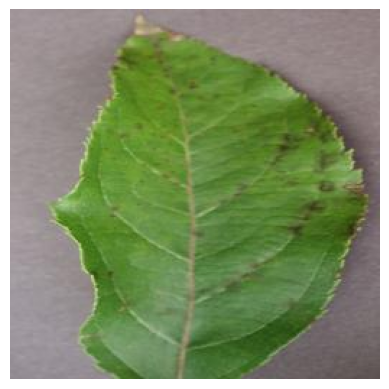

In [7]:
# TEST CODE
test_jpg = load_image('../data/PlantVillage/Apple___Apple_scab/image (1)')
plot_image(test_jpg)

In [8]:
# load all data
data = load_data(SELECTED_CROP)
NUM_CLASSES = len(data.keys())
print(f"Number of classes: {len(data.keys())}, Number of images: {sum([len(x) for x in data.values()])}")

Apple___Apple_scab 630
Apple___Black_rot 621
Apple___Cedar_apple_rust 275
Apple___healthy 1645
Number of classes: 4, Number of images: 3171


In [9]:
# normalize data
def normalize_data(data: dict) -> dict:
    return {k: [x/255.0 for x in v] for k, v in data.items()}

In [10]:
nor_data = normalize_data(data)
print(f"Number of classes: {len(nor_data.keys())}, Number of images: {sum([len(x) for x in nor_data.values()])}")

Number of classes: 4, Number of images: 3171


In [11]:
df = pd.DataFrame({'image': [x for x in nor_data.values() for x in x], 'label': [x for x in nor_data.keys() for _ in range(len(nor_data[x]))]})
df.head()

,image,label
0,"[[[0.6274509803921569, 0.5803921568627451, 0.5...",Apple___Apple_scab
1,"[[[0.4549019607843137, 0.43137254901960786, 0....",Apple___Apple_scab
2,"[[[0.5764705882352941, 0.5372549019607843, 0.6...",Apple___Apple_scab
3,"[[[0.48627450980392156, 0.48627450980392156, 0...",Apple___Apple_scab
4,"[[[0.592156862745098, 0.5686274509803921, 0.70...",Apple___Apple_scab


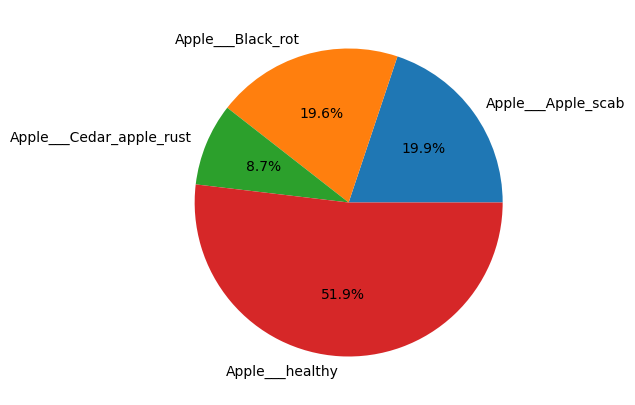

In [12]:
# plot pie chart of data(labels)
def plot_pie_chart(data: dict):
    plt.figure(figsize=(5, 5))
    plt.pie([len(x) for x in data.values()], labels=[x for x in data.keys()], autopct='%1.1f%%')
    plt.show()

plot_pie_chart(nor_data)

In [13]:
# label encoding
le = LabelEncoder()
le.fit(df['label'])
df['label'] = le.transform(df['label'])
for i, x in enumerate(le.classes_):
    print(f"Class {i}: {x}")

Class 0: Apple___Apple_scab
Class 1: Apple___Black_rot
Class 2: Apple___Cedar_apple_rust
Class 3: Apple___healthy


In [14]:
# turn data into numpy array and split into train and test
def split_data(data: dict, test_size: float=0.2) -> tuple:
    X = np.array([x for x in data['image']])
    y = np.array([x for x in data['label']])
    return train_test_split(X, y, test_size=test_size, random_state=42)

X_train, X_test, y_train, y_test = split_data(df)

In [15]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2536, 256, 256, 3), y_train shape: (2536,)
X_test shape: (635, 256, 256, 3), y_test shape: (635,)


In [16]:
type(X_train[0])

numpy.ndarray

In [17]:
# create model
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

opt = keras.optimizers.RMSprop(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)      

In [18]:
# train model

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


80/80 [==============================] - 39s 478ms/step - loss: 2.3125 - accuracy: 0.5477 - val_loss: 0.8635 - val_accuracy: 0.5843
Epoch 2/10
80/80 [==============================] - 38s 479ms/step - loss: 0.5443 - accuracy: 0.7981 - val_loss: 0.4977 - val_accuracy: 0.8283
Epoch 3/10
80/80 [==============================] - 39s 486ms/step - loss: 0.4062 - accuracy: 0.8573 - val_loss: 0.3529 - val_accuracy: 0.8835
Epoch 4/10
15/80 [====>.........................] - ETA: 30s - loss: 0.2435 - accuracy: 0.9125

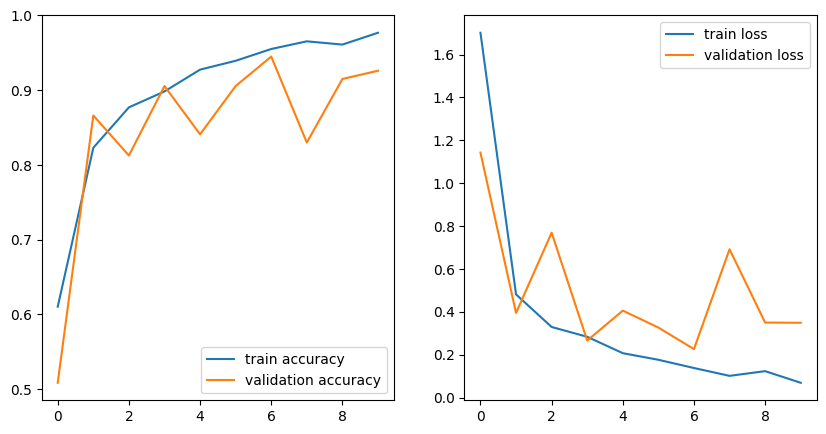

In [ ]:
# plot accuracy and loss

def plot_accuracy_and_loss(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.legend()
    plt.show()

plot_accuracy_and_loss(history)

20/20 [==============================] - 2s 111ms/step


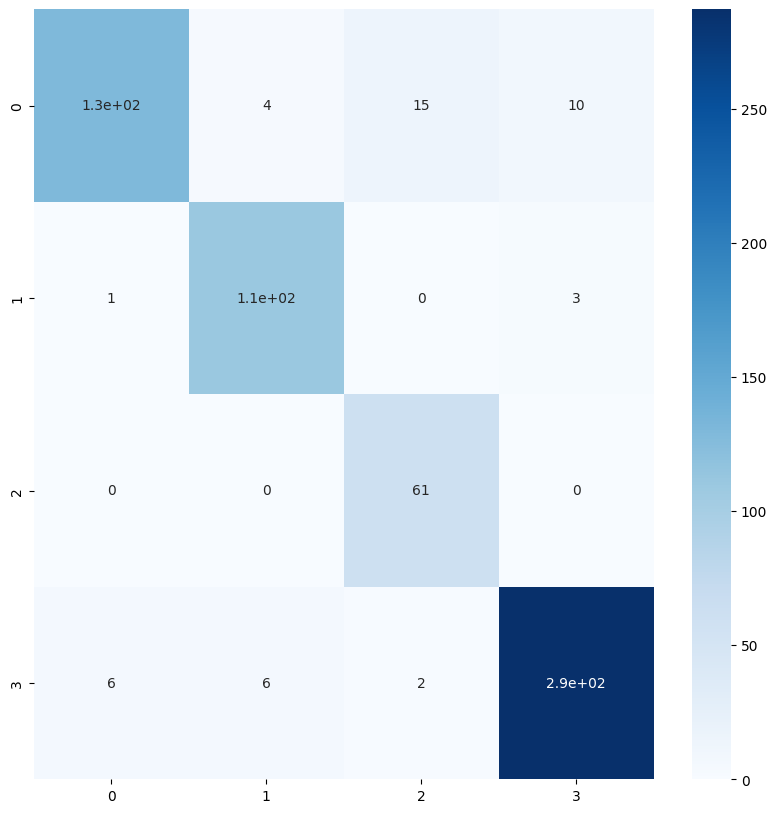

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.show()

In [ ]:
# save model
model.save(f'../models/{SELECTED_CROP}.keras')

In [ ]:
# save label encoder
with open(f'../models/{SELECTED_CROP}_le.pickle', 'wb') as f:
    pickle.dump(le, f)